# <center> <span style='color:yellow'> **Project 4: Classification. UPDATE**

Banks would like to be able to choose among their customers exactly those who are most likely to take advantage of a particular offer, and contact them.

You were provided with data on the latest marketing campaign conducted by the bank: the task was to attract customers to open a deposit. You must analyze this data, identify patterns and find the decisive factors that influenced the fact that the client invested money in this particular bank. If you can do this, you will raise the bank's income and help understand the target audience that needs to be attracted through advertising and various offers.

**Business task:** to determine the characteristics by which it is possible to identify customers who are more inclined to open a deposit in a bank, and thereby increase the effectiveness of a marketing campaign.

**Technical task:** to build a machine learning model that, based on the proposed characteristics of the client, will predict whether he will take advantage of the offer to open a deposit or not.

**Target value:** F1-score

**Bank customer data:**
- age (age);
- job (field of employment);
- marital (marital status);
- education (level of education);
- default (whether there is an overdue loan);
- housing (whether there is a loan for housing);
- loan (whether there is a loan for personal needs);
- balance (balance).

**Data related to the last contact in the context of the current marketing campaign:**
- contact (type of contact with the client);
- month (the month in which the last contact was made);
- day (the day the last contact was made);
- duration (contact duration in seconds).

**Other signs:**
- campaign (number of contacts with this client during the current campaign);
- pdays (the number of days missed from the last marketing campaign to the contact in the current campaign);
- previous (number of contacts before the current campaign)
- poutcome (the result of a past marketing campaign).

**Target variable is deposit**, which determines whether the client agrees to open a deposit with the bank. This is what we will try to predict in this case.

In [2]:
# main
import pandas as pd
import numpy as np
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, RFE
from sklearn import ensemble, metrics, tree, linear_model
from sklearn.preprocessing import PolynomialFeatures
# machine learning
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import optuna
from sklearn.model_selection import cross_val_score, cross_validate

# ensembles
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingRegressor, StackingClassifier
from sklearn.ensemble import IsolationForest
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, space_eval

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import joblib

# coders
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import colors
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go

## <center> <span style='color:red'> **Part I. Data Explore and Cleaning**

In [3]:
# load and explore our data
data = pd.read_csv('bank_fin.csv', sep = ';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# let's check for full duplicates
data.duplicated().sum()

0

In [5]:
# continue exploring our data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [6]:
# check for gaps in our data
data.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

#### <span style='color:green'> **Education and Job**

In [7]:
# are there any missing values in the 'education'?
data['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [8]:
# are there any missing values in the 'job'?
data['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [9]:
# fill in the gaps with modal values
data['education'] = data['education'].replace('unknown', 'secondary')
data['job'] = data['job'].replace('unknown', 'management')

#### <span style='color:green'> **Balance**

In [10]:
# handle the balance 
def balance_changing (row):
    """func for work with 'balance' column"""
    
    row = str(row)
    
    if row != 'unknown':
        row = row.replace('$', '')
        row = row.replace(' ', '')
        row = row.replace(',00', '')
        return row
    
    else:
        return np.nan


# update this feature
data['balance'] = data['balance'].apply(balance_changing)

# this column has object type, let's fix this
data['balance'] = data['balance'].astype(float)

# let's fill in missing values in balance by a mean value
data['balance'] = data['balance'].fillna(data['balance'].median())

In [11]:
# discard outliers for the balance feature
# firstly let's check a distribution of this feature
hist_balance = px.histogram(
    data_frame=data,
    x='balance',
    marginal='box',
    width=1000,
    title='Balance distribution'
)

hist_balance.update_layout(title=dict(x=.5, xanchor='center'))

hist_balance.show()

In [12]:
# will use tykey method
# looks like almost normal distribution
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    """Func for the interquartile range method"""
    
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    
    return outliers, cleaned


# use this func for the balance
outliers, cleaned = outliers_iqr_mod(data, 'balance')

# update our dataset by the cleaned data
data = cleaned


## <center> <span style='color:red'> **Part II. Exploratory Data Analysis**

In [13]:
# we will use this color palette for a more transparent visualization
color_map = {"no": "red", "yes": "green"} 

### <center> <span style='color:blue'> **TARGET VALUE**

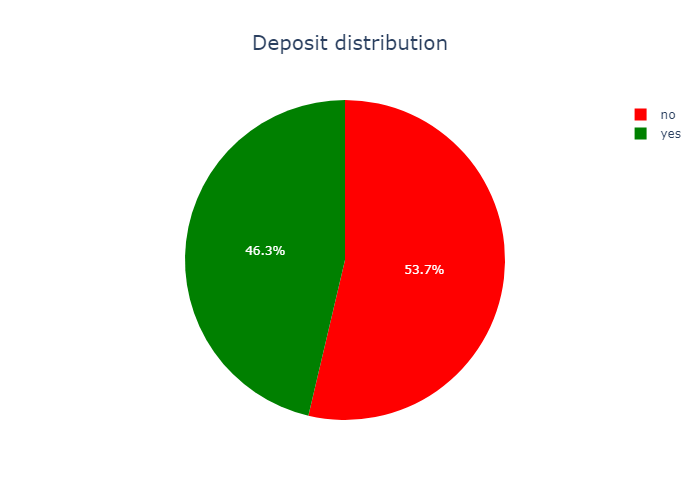

In [14]:
# firstly let's check distribution of the target value
deposit_distribution = px.pie(
    data_frame=data,
    names='deposit',
    title='Deposit distribution',
    color='deposit',
    color_discrete_map=color_map
)

deposit_distribution.update_layout(
    title=dict(x=.5, xanchor="center"),
    title_font_size=20
)

# display this plot
deposit_distribution.show('png')

**Conclusion:**  
The distribution by the presence a deposit is almost equal, but a smaller number of people have a deposit in this data. It means a stratified splitting should be used.

### <center> <span style='color:blue'> **NUMERICAL FEATURES**  

In [15]:
# descriptive statistics for numerical features
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


#### <span style='color:green'> **Age**  

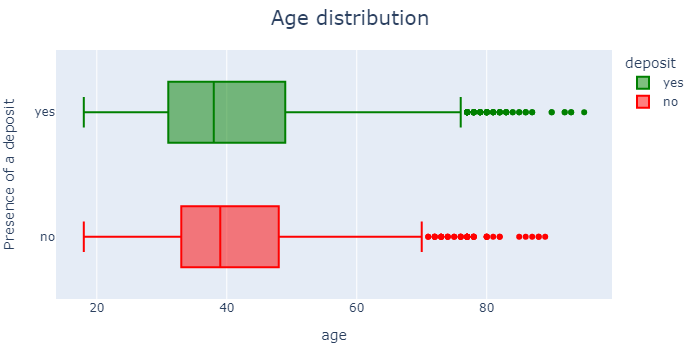

In [16]:
# explore age feature
age_boxplot = px.box(
    data_frame=data,
    x='age',
    y='deposit',
    color='deposit',
    title='Age distribution',
    height=350,
    width=700,
    color_discrete_map=color_map
)
age_boxplot.update_layout(title=dict(x=.5, xanchor='center'),
                          margin=dict(l=10, r=10, t=50, b=50),
                          title_font_size=20,
                          yaxis_title='Presence of a deposit')

# display the plot
age_boxplot.show('png')

**Conclusion:**  
Seems an age over 71 and 77 years could be a abnormal value. Perhaps it should be taken into account at the stage of a machine learning. Generally people with deposit have more wider range of ages, but the median value is slightly larger more in 'no' category.  
Let's see more carefully.

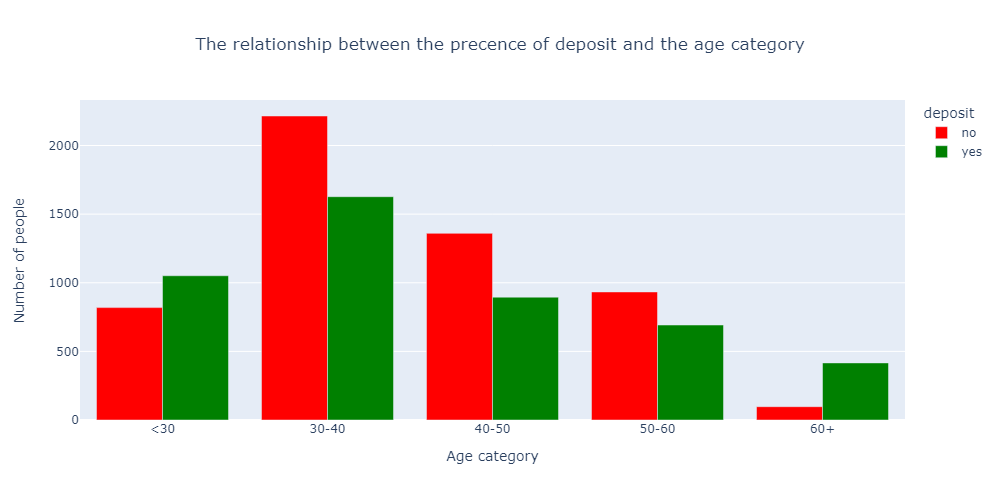

In [17]:
# create categorical age
data['age_cat'] = pd.cut(data.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])

# group data
deposit_age_df = data.groupby('age_cat', as_index=False)['deposit'].value_counts().sort_values(by=['age_cat', 'count'])

# picturaze
deposit_age_plot = px.bar(
    data_frame = deposit_age_df,
    x='age_cat',
    y='count',
    title='The relationship between the precence of deposit and the age category',
    color='deposit',
    barmode='group',
    width=1000,
    color_discrete_map=color_map
)

# add names
deposit_age_plot.update_layout(
    xaxis_title='Age category',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center')
)

# display
deposit_age_plot.show('png')

**Conclusion:**  
Only the 'young' and the 'retired' are more likely to agree opening a deposit.  
Let's evaluate the probability of refusal to take a deposit for each age category.

In [18]:
# firstly we should get this rate
def get_failure_rate_age(age):
    """Func to calculate bounce rate for the day feature"""
    
    ratio = round(len(data[(data['deposit'] == 'no') & (data['age_cat'] == age)])  / (len(data[data['age_cat'] == age])), 2)
    
    return float(ratio)

# create new feature for work
data['fail_rate_age'] = data['age_cat'].apply(get_failure_rate_age).astype(float)

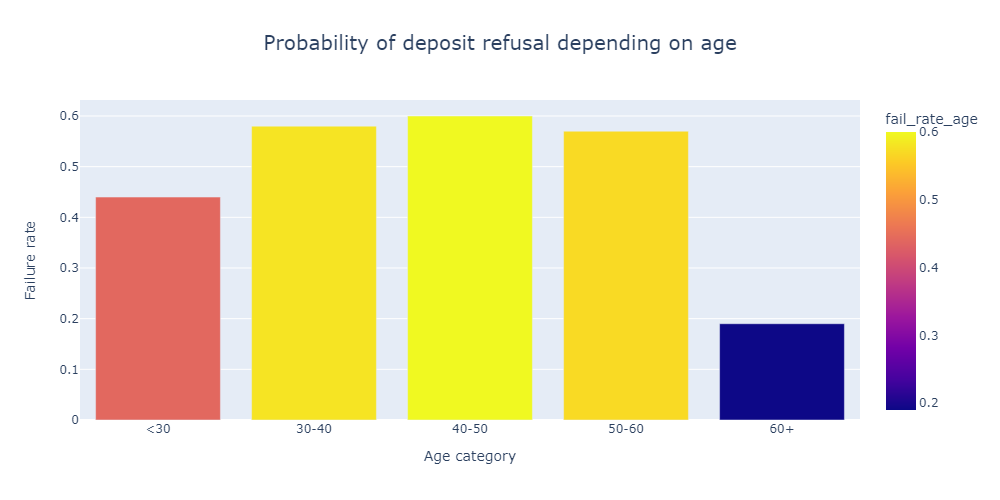

In [19]:
# let's see the result
fail_age_df = data.groupby('age_cat', as_index=False)['fail_rate_age'].value_counts()
fail_age_df = fail_age_df[fail_age_df['count'] > 0]

# picturaze
fail_age_plot = px.bar(
    data_frame = fail_age_df,
    x='age_cat',
    y='fail_rate_age',
    title='Probability of deposit refusal depending on age',
    color='fail_rate_age',
    width=1000
)

# add captures
fail_age_plot.update_layout(
    xaxis_title='Age category',
    yaxis_title='Failure rate',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

# display the plot
fail_age_plot.show('png')

**Conclusion:**  
It seems we were only partly right. Category 60+ has 2.5 times less probability of rejection than category <30.

#### <span style='color:green'> **Balance**  

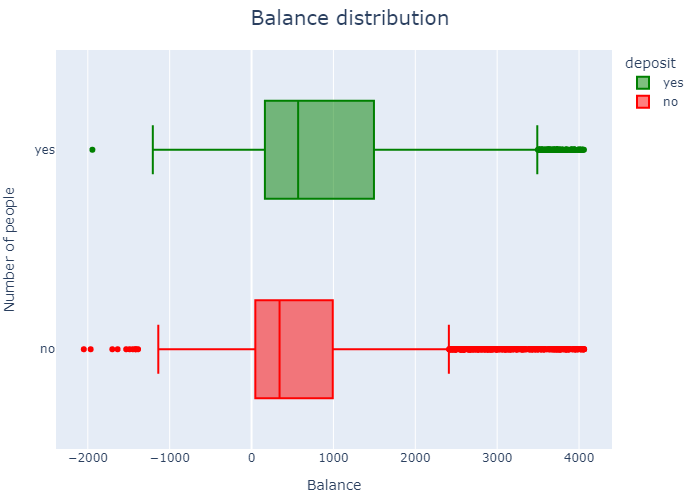

In [20]:
# explore balance feature
balance_boxplot = px.box(
    data_frame=data,
    x='balance',
    y='deposit',
    color='deposit',
    title='Balance distribution',
    color_discrete_map=color_map
)
balance_boxplot.update_layout(
    yaxis_title='Number of people',
    xaxis_title='Balance',
    title_font_size=20,
    title=dict(x=.5, xanchor='center'),
    margin=dict(l=10, r=10, t=50, b=50))

# display the plot
balance_boxplot.show('png');

**Conclusion:**  
People with a deposit have more money on their account. But almost equal number of people in both groups have a negative balance.

#### <span style='color:green'> **Day**  

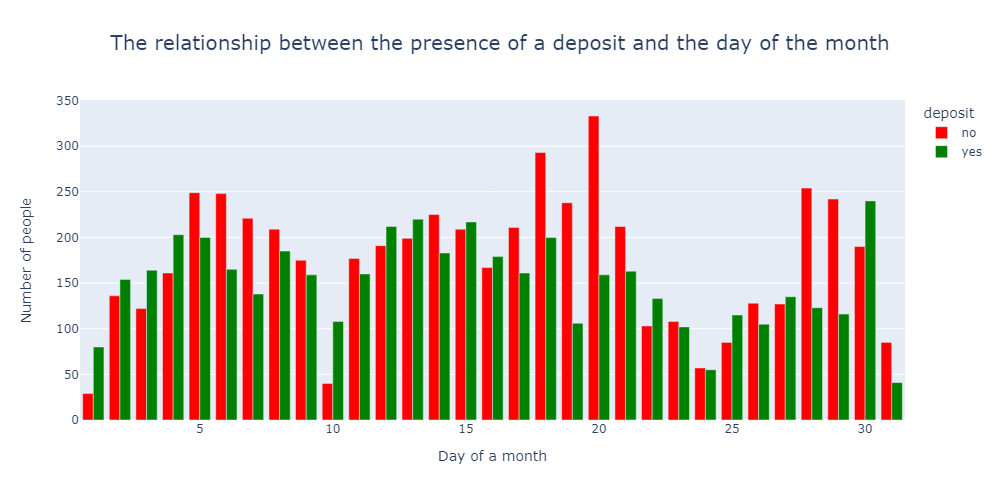

In [21]:
# group the data
last_contact = data.groupby(['day', 'deposit'], as_index=False).count()

# study the significance of the day of the month
last_contact_day = px.bar(
    data_frame=last_contact,
    x='day',
    y='contact',
    color='deposit',
    barmode = 'group',
    title='The relationship between the presence of a deposit and the day of the month',
    width=1000,
    color_discrete_map=color_map
)

# add captions
last_contact_day.update_layout(
    xaxis_title='Day of a month',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center',
    font_size=20)
)

# dispaly the plot
last_contact_day.show('png')

**Conclusion:**  
Not so obvious, but in the first and last days and also in the middle of a month, the number of people who were taken a deposit, is bigger. Let's try to evaluate the days of a month by their success more carefully - let's introduce a new feature - the probability of failure by the days of the month.

In [22]:
# firstly we should get this rate
def get_failure_rate_day(day):
    """Func to calculate bounce rate for the day feature"""
    
    ratio = round(len(data[(data['deposit'] == 'no') & (data['day'] == day)])  / (len(data[data['day'] == day])), 2)
    
    return ratio

# create new feature for work
data['fail_rate_day'] = data['day'].apply(get_failure_rate_day).astype(float)

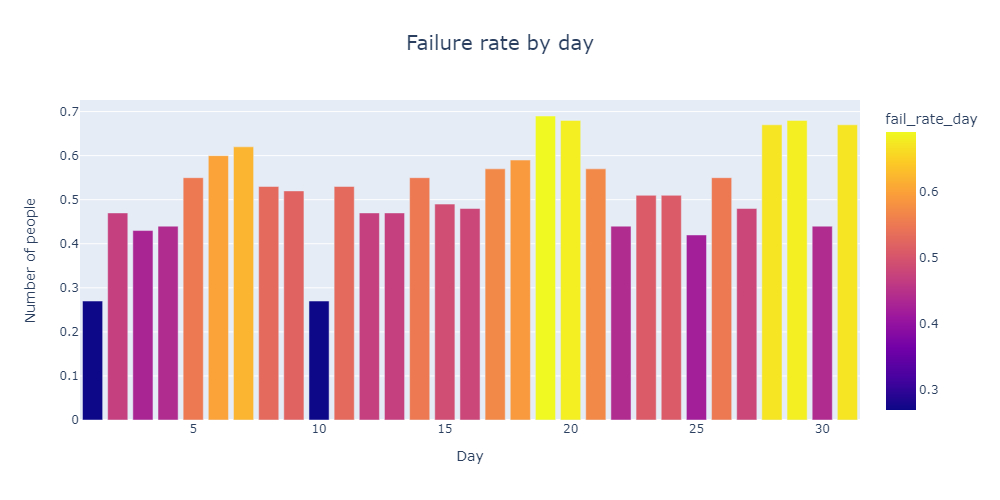

In [23]:
# let's see the result
fail_day_df = data.groupby('day', as_index=False)['fail_rate_day'].value_counts(normalize=False)

# picturaze
fail_day_plot = px.bar(
    data_frame = fail_day_df,
    x='day',
    y='fail_rate_day',
    title='Failure rate by day',
    color='fail_rate_day',
    width=1000
)

# add captures
fail_day_plot.update_layout(
    xaxis_title='Day',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

# display the plot
fail_day_plot.show('png')

**Conclusion:**  
As we can see the higher result the bigger chance for reject. The 1st and the 10th day of a month are the best day for a deposit offer.

#### <span style='color:green'> **Duration**  

In [24]:
data['duration_cat'] = pd.cut(data.duration, [0, 60, 180, 300, 600, 10000], labels=['<1 min', '<3 min', '<5 min', '<10 min', '>10 min'])

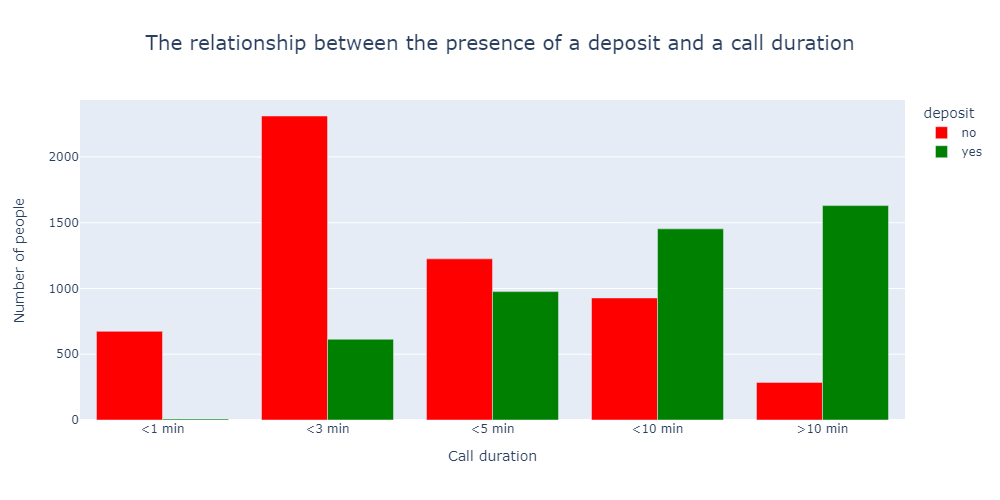

In [25]:
# group the data
duration_df = data.groupby('duration_cat', as_index=False)['deposit'].value_counts()

# study the significance of the day of the month
duration_deposit_plot = px.bar(
    data_frame=duration_df,
    x='duration_cat',
    y='count',
    color='deposit',
    barmode = 'group',
    title='The relationship between the presence of a deposit and a call duration',
    width=1000,
    color_discrete_map=color_map
)

# add captions
duration_deposit_plot.update_layout(
    xaxis_title='Call duration',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center',
    font_size=20)
)

# dispaly the plot
duration_deposit_plot.show('png')

**Conclusion:**  
With an increase in the duration of the call, the probability of taking a deposit increases. Let's calculate the failure chance.

In [26]:
# firstly create this rating
def get_failure_rate_duration(duration):
    """Func to calculate bounce rate for the day feature"""
    
    ratio = round(len(data[(data['deposit'] == 'no') & (data['duration_cat'] == duration)])  / (len(data[data['duration_cat'] == duration])), 2)
    
    return ratio

# create new feature for work
data['fail_rate_duration'] = data['duration_cat'].apply(get_failure_rate_duration).astype(float)

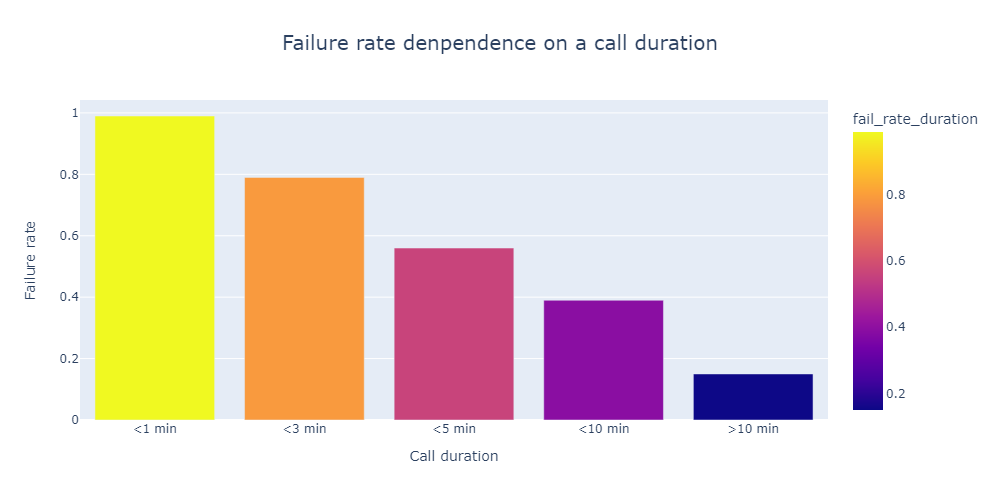

In [27]:
# let's see the result
fail_duration_df = data.groupby('duration_cat', as_index=False)['fail_rate_duration'].value_counts()
fail_duration_df = fail_duration_df[fail_duration_df['count'] > 0]

# picturaze
fail_duration_plot = px.bar(
    data_frame = fail_duration_df,
    x='duration_cat',
    y='fail_rate_duration',
    title='Failure rate denpendence on a call duration',
    color='fail_rate_duration',
    width=1000
)

# add captures
fail_duration_plot.update_layout(
    xaxis_title='Call duration',
    yaxis_title='Failure rate',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

# display the plot
fail_duration_plot.show('png')

**Conclusion:**  
Our last conclusion was true. The chance for refuse in call duration less a minute is almost 100%, but it declines with every minute.

#### <span style='color:green'> **Previous**  

In [28]:
data['previous_cat'] = pd.cut(data.previous, [-1, 0, 1, 2, 5, 10, 100], labels=['0 times', 'once', 'twice', '<5 times', '<10 times', '>10 times'])

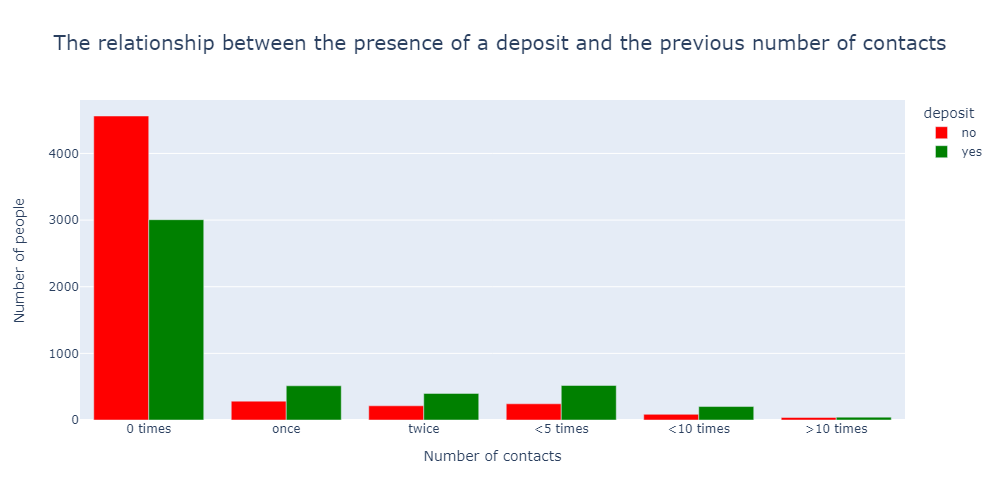

In [29]:
# group the data
cont_number_df = data.groupby('previous_cat', as_index=False)['deposit'].value_counts()

# study the significance of the day of the month
cont_number_plot = px.bar(
    data_frame=cont_number_df,
    x='previous_cat',
    y='count',
    color='deposit',
    barmode = 'group',
    title='The relationship between the presence of a deposit and the previous number of contacts',
    width=1000,
    color_discrete_map=color_map
)

# add captions
cont_number_plot.update_layout(
    xaxis_title='Number of contacts',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center',
    font_size=20)
)

# dispaly the plot
cont_number_plot.show('png')

**Conclusion:**  
With an increase in the number of contacts, the probability of taking a deposit increases. Let's calculate the failure chance again.

In [30]:
# firstly create this rating
def get_failure_rate_contacts(previous):
    """Func to calculate bounce rate for the day feature"""
    
    ratio = round(len(data[(data['deposit'] == 'no') & (data['previous_cat'] == previous)])  / (len(data[data['previous_cat'] == previous])), 2)
    
    return ratio

# create new feature for work
data['fail_rate_previous'] = data['previous_cat'].apply(get_failure_rate_contacts).astype(float)

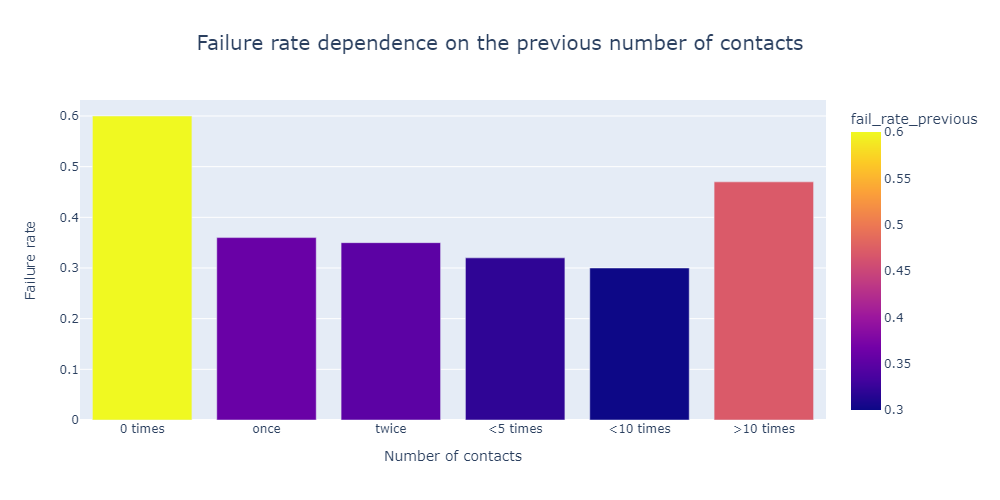

In [31]:
# let's see the result
fail_previous_df = data.groupby('previous_cat', as_index=False)['fail_rate_previous'].value_counts()
fail_previous_df = fail_previous_df[fail_previous_df['count'] > 0]

# picturaze
fail_previous_plot = px.bar(
    data_frame = fail_previous_df,
    x='previous_cat',
    y='fail_rate_previous',
    title='Failure rate dependence on the previous number of contacts',
    color='fail_rate_previous',
    width=1000
)

# add captures
fail_previous_plot.update_layout(
    xaxis_title='Number of contacts',
    yaxis_title='Failure rate',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

# display the plot
fail_previous_plot.show('png')

**Conclusion:**  
Our last conclusion was true. But the probability of rejection increases dramatically if more than 10 contacts were made.

#### <span style='color:green'> **Pdays**  

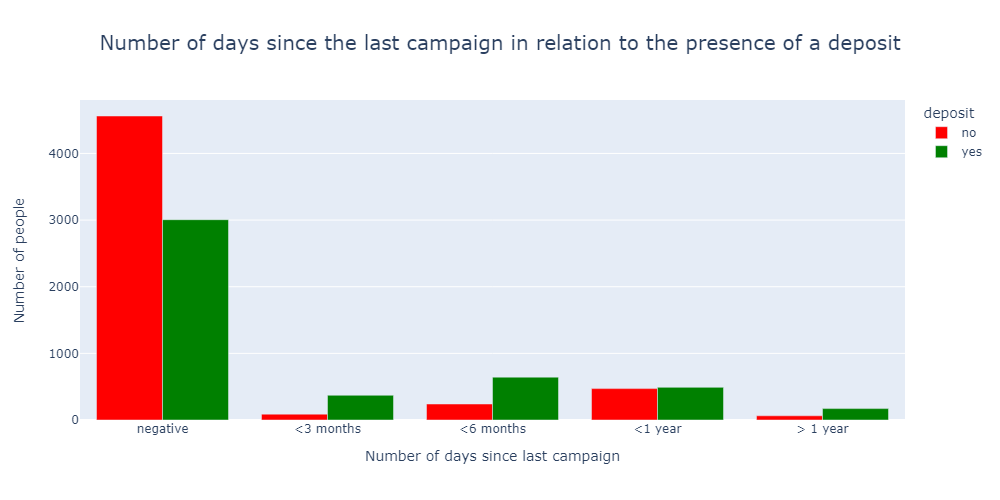

In [32]:
data['pdays_cat'] = pd.cut(data.pdays, [-100, 0, 92, 183, 365, 9999], labels = ['negative', '<3 months', '<6 months', '<1 year', '> 1 year'])

# let's compare l
pdays_df = data.groupby('pdays_cat', as_index=False)['deposit'].value_counts()

# let's take a closer look
pdays_plot = px.bar(
    data_frame=pdays_df,
    x='pdays_cat',
    y='count',
    color='deposit',
    barmode = 'group',
    title='Number of days since the last campaign in relation to the presence of a deposit',
    width=1000,
    color_discrete_map=color_map
)

pdays_plot.update_layout(
    xaxis_title='Number of days since last campaign',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

# display this plot
pdays_plot.show('png')

**Conclusion:**  
We have a very large amount of data that is essentially unknown and uninterpretable. However, as the time to the current campaign increases, the probability of rejection decreases.

### <center> <span style='color:blue'> **CATEGORICAL FEATURES**  

In [33]:
# descriptive statistics for categorical features
data.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


#### <span style='color:green'> **Month**  

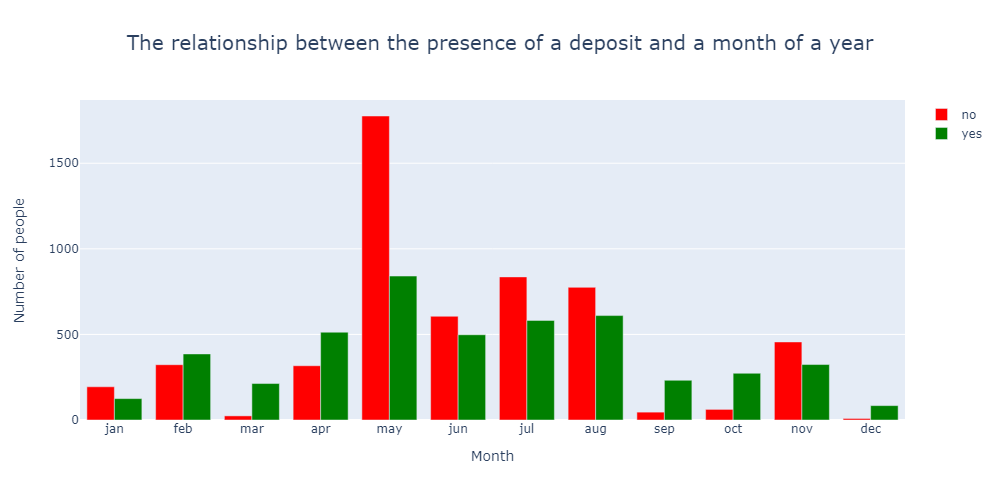

In [34]:
# create a month list for prettier visualisation
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

# group the data
grouped_by_month = data.groupby('month')['deposit'].value_counts(normalize=False).unstack().reset_index()

# study the influence of the month of the year on the availability of a deposit
fig = go.Figure(data=[
    go.Bar(name='no ', x=grouped_by_month['month'], y=grouped_by_month['no'], marker_color='red'),
    go.Bar(name='yes', x=grouped_by_month['month'], y=grouped_by_month['yes'], marker_color='green')
])

# add caprionts and sorting
fig.update_layout(
    barmode='group',
    xaxis={'categoryarray': months},
    xaxis_title='Month',
    yaxis_title='Number of people',
    title='The relationship between the presence of a deposit and a month of a year',
    width=1000
)

fig.update_layout(
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

# display this plot
fig.show('png')

**Conclusion:**  
Seems the most successful months were May and summer, because the largest number of deposits were taken during that time. Also seems the beginning and the end of a year are not useful periods for any campaign.  
But we can see a huge number of failure at May. Thus we should estimate success of a month in terms of the ration refusals to all proposals.

Let's calculate which month has the highest percentage of interaction failures in the current marketing campaign.

In [35]:
# firstly we should get this rate
def get_failure_rate(month):
    """Func to calculate bounce rate"""
    
    ratio = len(data[(data['deposit'] == 'no') & (data['month'] == month)])  / len(data[data['month'] == month])
    
    return ratio

# create new feature for work
data['fail_rate_month'] = data['month'].apply(get_failure_rate)

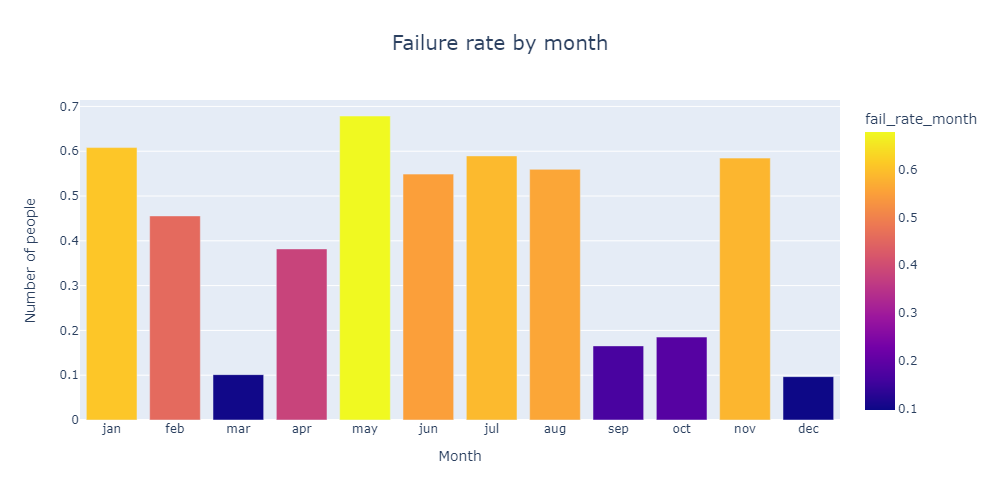

In [36]:
# let's see the result
fail_month_df = data.groupby('month', as_index=False)['fail_rate_month'].value_counts(normalize=False)

# month must be in order
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

# picturaze
fail_rate_plot = px.bar(
    data_frame = fail_month_df,
    x='month',
    y='fail_rate_month',
    title='Failure rate by month',
    color='fail_rate_month',
    width=1000
)

fail_rate_plot.update_layout(
    xaxis_title='Month',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20,
    xaxis={'categoryarray': months}
)
fail_rate_plot.show('png')

**Conclusion:**  
There is a suddenly absolutely reverse result in this plot. Lately we haven't noticed december and march, but these months can show impressive results.  
So I mean there was the biggest number of deposits in May, but only because of a more active offer.

#### <span style='color:green'> **Poutcome**   

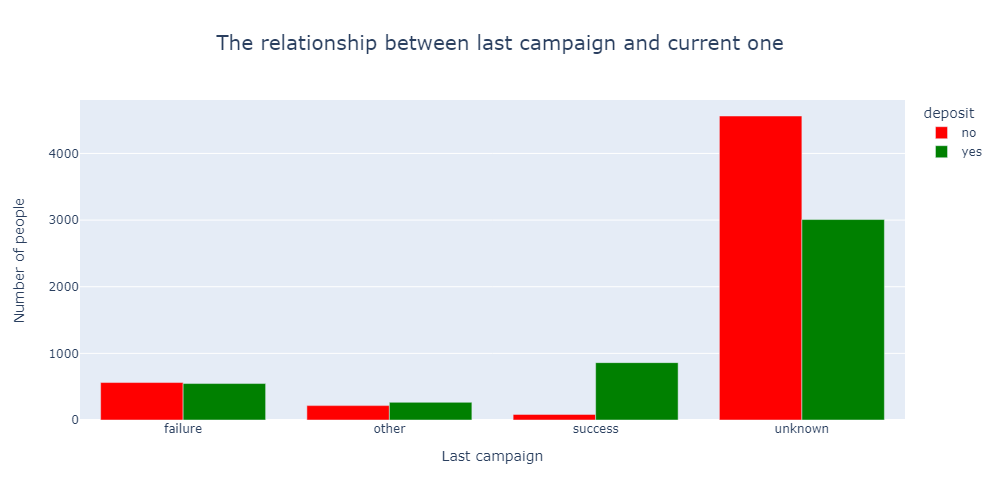

In [37]:
# let's compare last campaign and the current one
last_campaign = data.groupby('poutcome', as_index=False)['deposit'].value_counts()

# let's picturaze it
last_camp_plot = px.bar(
    data_frame=last_campaign,
    x='poutcome',
    y='count',
    color='deposit',
    barmode = 'group',
    title='The relationship between last campaign and current one',
    width=1000,
    color_discrete_map=color_map
)

# add captions
last_camp_plot.update_layout(
    xaxis_title='Last campaign',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

# display this plot
last_camp_plot.show('png')

**Conclusion:**  
For God's sake... Seems this compaign is more successful.

#### <span style='color:green'> **Marital**

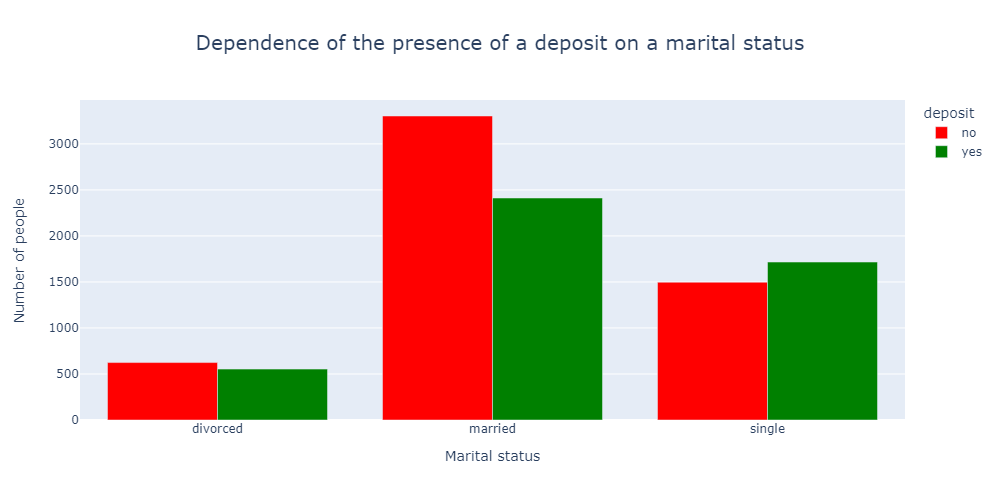

In [38]:
# group our data
marital_grouped = data.groupby('marital', as_index=False)['deposit'].value_counts()

# picturaze
deposit_on_marital_plot = px.bar(
    data_frame=marital_grouped,
    x='marital',
    y='count',
    color='deposit',
    barmode='group',
    title='Dependence of the presence of a deposit on a marital status',
    width=1000,
    color_discrete_map=color_map
)

deposit_on_marital_plot.update_layout(
    xaxis_title='Marital status',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

deposit_on_marital_plot.show('png')

**Conclusion:**  
The divorced and married people are more likely to refuse deposit offers.

#### <span style='color:green'> **Education**

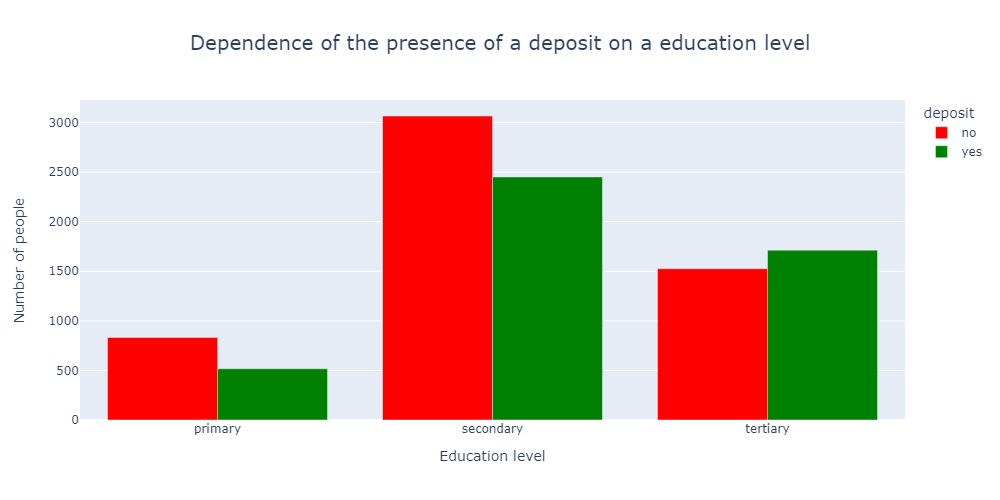

In [39]:
# build visualizations for those who have opened and not opened a deposit, depending on the education
# group our data
education_grouped = data.groupby('education', as_index=False)['deposit'].value_counts()

# picturaze
deposit_education_plot = px.bar(
    data_frame=education_grouped,
    x='education',
    y='count',
    color='deposit',
    barmode='group',
    title='Dependence of the presence of a deposit on a education level',
    width=1000,
    color_discrete_map=color_map
)

deposit_education_plot.update_layout(
    xaxis_title='Education level',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

deposit_education_plot.show('png')

**Conclusion:**  
People with a higher level of education are more likely to take a deposit.

#### <span style='color:green'> **Job**

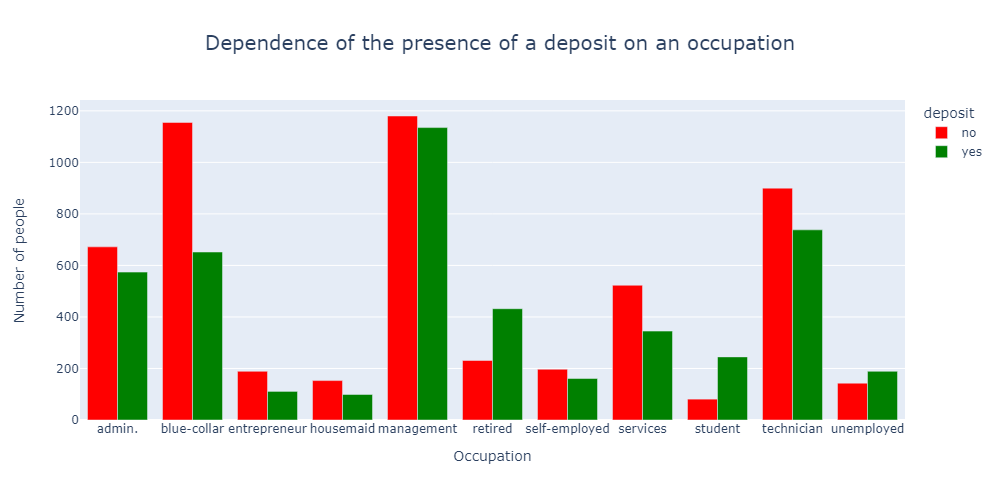

In [40]:
# build visualizations for those who have opened and not opened a deposit,
# depending on the type of professional employment
# group our data
job_grouped = data.groupby('job', as_index=False)['deposit'].value_counts()

# picturaze
deposit_job_plot = px.bar(
    data_frame=job_grouped,
    x='job',
    y='count',
    color='deposit',
    barmode='group',
    title='Dependence of the presence of a deposit on an occupation',
    width=1000,
    color_discrete_map=color_map
)
# add names
deposit_job_plot.update_layout(
    xaxis_title='Occupation',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

# display
deposit_job_plot.show('png')

**Conclusion:**  
So most often the retired, students and the unemployed have a deposit. That is quite obvious, since these categories prefer more conservative investments.

#### <span style='color:green'> **Contact**

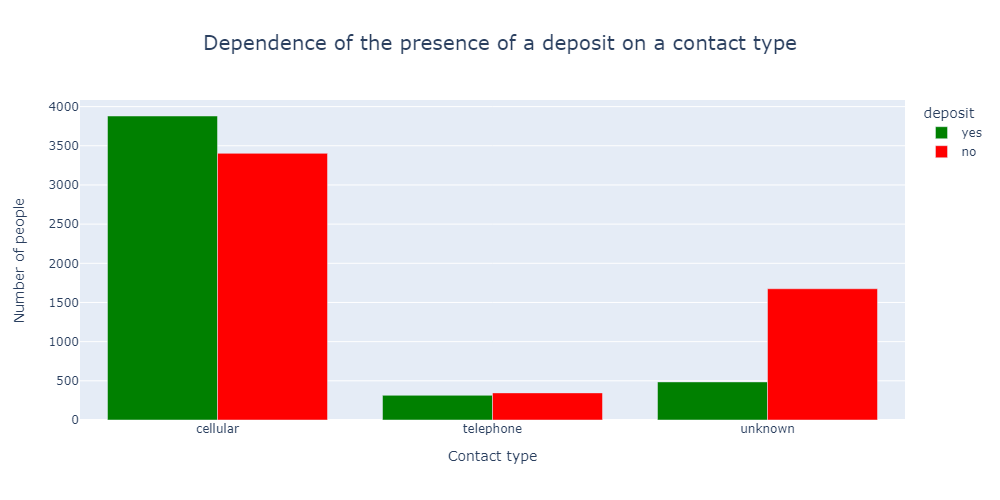

In [41]:

# group our data
contact_grouped = data.groupby('contact', as_index=False)['deposit'].value_counts()

# picturaze
deposit_contact_plot = px.bar(
    data_frame=contact_grouped,
    x='contact',
    y='count',
    color='deposit',
    barmode='group',
    title='Dependence of the presence of a deposit on a contact type',
    width=1000,
    color_discrete_map=color_map
)

deposit_contact_plot.update_layout(
    xaxis_title='Contact type',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

deposit_contact_plot.show('png')

**Conclusion:**  
We can see that in a group where the contact type is unknown, the probability of failure is almost 4 times higher.

## <center> <span style='color:red'> **Part III. Selection and transformation of features**

### <center><span style='color:blue'> **ENCODING AND REMOVING**

In [42]:
# encoding 'education' separetely
label_encoder = LabelEncoder()
data['education'] = label_encoder.fit_transform(data['education'])

In [43]:
# encoding target variable
data['deposit'] = data['deposit'].apply(lambda x: 1 if x=='yes' else 0)

In [44]:
# encoding binary features
binary_encoder = lambda x: 1 if x=='yes' else 0

# use this func
data['default'] = data['default'].apply(binary_encoder)
data['housing'] = data['housing'].apply(binary_encoder)
data['loan'] = data['loan'].apply(binary_encoder)

In [45]:
# use dummies for the rest categorical features
data = pd.get_dummies(data, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

In [46]:
# remove waste features
data = data.drop(['age_cat', 'duration_cat', 'previous_cat', 'pdays_cat'], axis=1)

### <center> <span style='color:blue'> **CHECK CORRELATION**

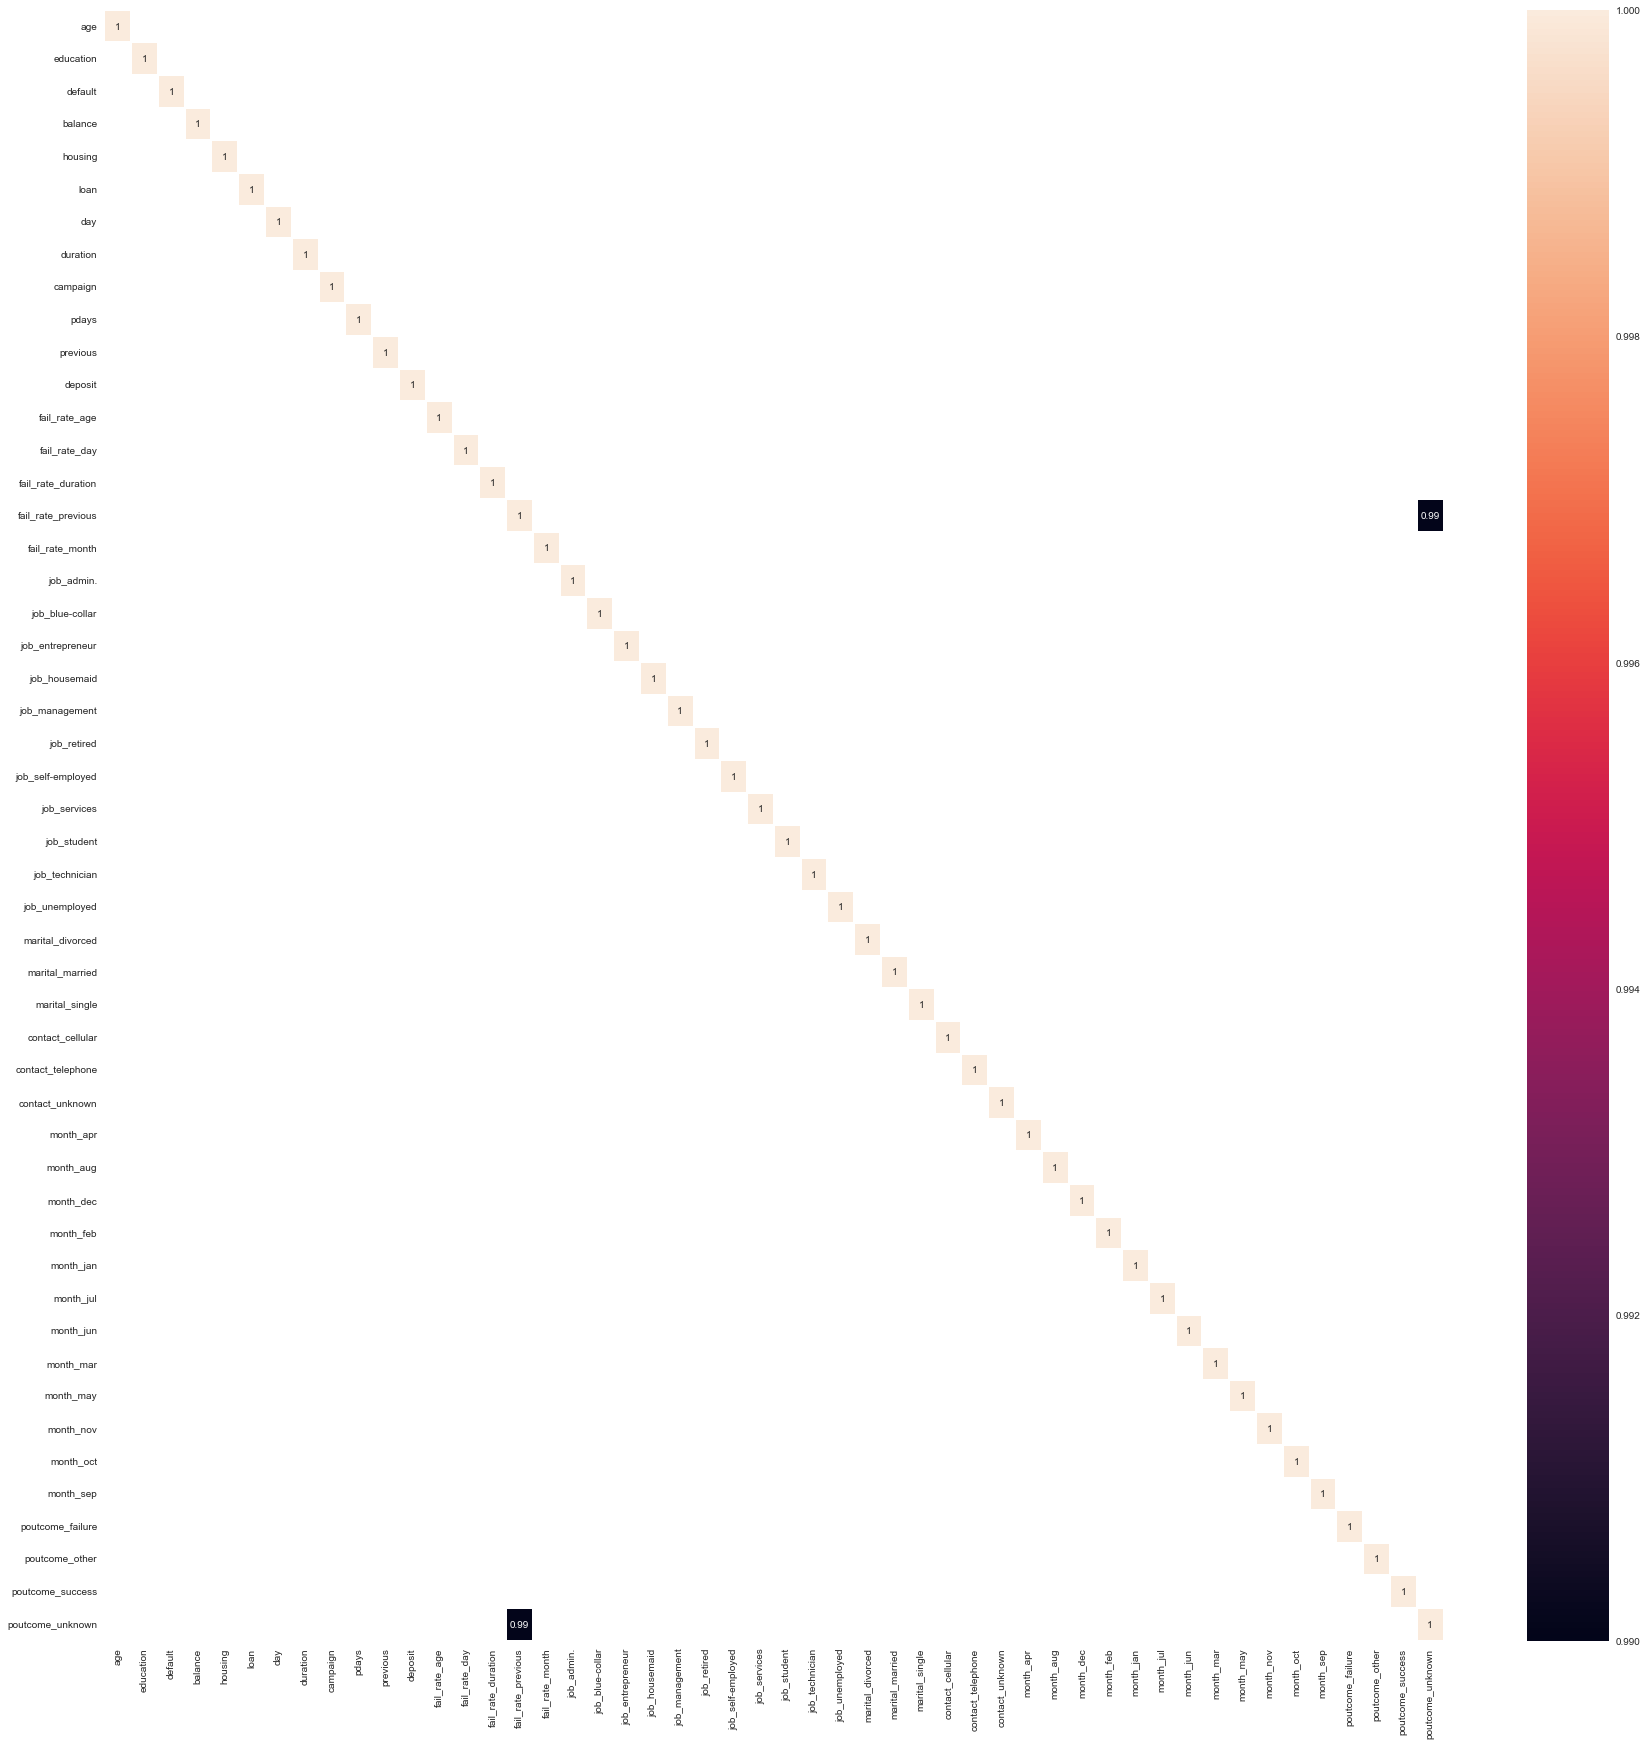

In [47]:
# build heatmap for searching multicollinear features
corr = data.corr()
fig = plt.figure(figsize=(30,30))
sns.heatmap(round(corr[corr.abs() > 0.9], 2), annot=True, linewidths=0.1);

**Conclusion:**  
We will consider multicollinear features only those for which correletaion is more than |0.9|. We have a multicollinear feature. Let's get rid of it.

In [48]:
# remove the multicolliary feature
data = data.drop(['fail_rate_previous'], axis=1)

### <center> <span style='color:blue'> **IMPACT ON THE TARGET VALUE**

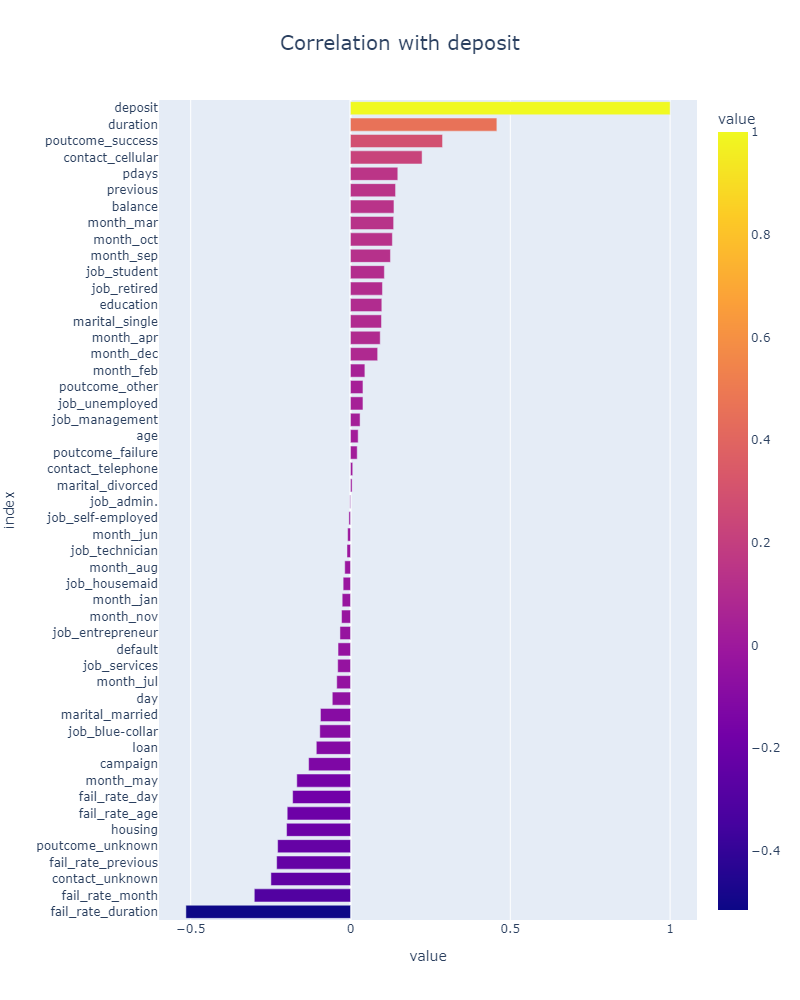

In [49]:
# now let's see a correlation with the target feature
# group data
corr_df = round(corr['deposit'].sort_values(ascending=True), 3)

# picturaze
deposit_corr = px.bar(
    data_frame=corr_df,
    orientation='h',
    color='value',
    height=1000,
    width=800,
    title='Correlation with deposit'
)
deposit_corr.update_layout(title=dict(x=.5, xanchor='center'),
                           title_font_size=20)

# display
deposit_corr.show('png')

**Conclusion:**  
The most important features are both features of call duration, with the duration rating we created being the most important. The rest of the created features also have a big impact on the target feature.

## <center> <span style='color:red'> **Part IV. Machine Learning**

### <center> <span style='color:blue'> **PREPARING**

In [50]:
# create X and y
X = data.drop(['deposit'], axis=1)
y = data['deposit']

# spliting 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print('Training sample size is:', X_train.shape)
print('Testing sample size is:', X_test.shape)

Training sample size is: (6770, 48)
Testing sample size is: (3335, 48)


In [51]:
# our data needs to be normalized.
scaler = MinMaxScaler()

# apply to sample
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### <center> <span style='color:blue'> **LOGISTIC REGRESSION**

#### <span style='color:green'> **Simple model**  

In [52]:
# build a simple logistic regression model
log_reg = linear_model.LogisticRegression(
    random_state=42,
    solver='sag',
    max_iter=1000
)

# training the model
log_reg.fit(X_train, y_train)

# predict and calculate metrics for training
y_train_pred = log_reg.predict(X_train)
print('Train F1-score: {:.4f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Train accuracy: {:.4f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('_'*25)

# predict and calculate metrics for testing
y_test_pred = log_reg.predict(X_test)
print('Test F1-score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train F1-score: 0.8234
Train accuracy: 0.8365
_________________________
Test F1-score: 0.8127
Test accuracy: 0.8261


#### <span style='color:green'> **Polynomial Regression Model**  

In [53]:
# try to use polinimoal features
poly = PolynomialFeatures(degree=2, include_bias=False)

# use it for our samples
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

# training the model щт polynomial data
log_reg.fit(X_train_poly, y_train)

# predict and calculate metrics for training
y_train_pred_poly = log_reg.predict(X_train_poly)
print('Train F1-score: {:.4f}'.format(metrics.f1_score(y_train, y_train_pred_poly)))
print('Train accuracy: {:.4f}'.format(metrics.accuracy_score(y_train, y_train_pred_poly)))
print('_'*25)

# predict and calculate metrics for testing
y_test_pred_poly = log_reg.predict(X_test_poly)
print('Test F1-score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred_poly)))

Train F1-score: 0.8788
Train accuracy: 0.8861
_________________________
Test F1-score: 0.8127
Test accuracy: 0.8447


#### <span style='color:green'> **Optimization**  

In [54]:
def optuna_1(trial):
    """function to iterate over hyperparameters from the first set
    
    Args:
        trial : hyperparameter class
      
    Returns:
        score(float): target metric - F1
    """
    
    # space for searching
    penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sag', 'newton-cg'])
    C = trial.suggest_float('C', 0.1, 1)  
    
    # build a model
    model = linear_model.LogisticRegression(
        penalty = penalty,
        solver = solver,
        C=C,
        random_state=42,
        max_iter=50)   
    
    # training the model
    model.fit(X_train_poly, y_train)
    
    # compete a cross validation
    score = cross_val_score(model, X_train_poly, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    
    return score


def optuna_2(trial):
    """function to iterate over hyperparameters from the second set
    
    Args:
        trial : hyperparameter class
      
    Returns:
        score(float): target metric - F1
    """
    
    # space for searching
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    C = trial.suggest_float('C', 0.1, 1)  
    
    # build a model
    model = linear_model.LogisticRegression(
        penalty = penalty,
        solver = solver,
        C=C,
        random_state=42,
        max_iter=50)   
    
    # training the model
    model.fit(X_train_poly, y_train)
    
    # compete a cross validation
    score = cross_val_score(model, X_train_poly, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    
    return score


def optuna_3(trial):
    """function to iterate over hyperparameters from the third set
    
    Args:
        trial : hyperparameter class
      
    Returns:
        score(float): target metric - F1
    """
    
    # space for searching
    penalty = trial.suggest_categorical('penalty', ['elasticnet', 'none'])
    solver = trial.suggest_categorical('solver', ['saga'])
    C = trial.suggest_float('C', 0.1, 1)
    l1_ratio = trial.suggest_float('l1_ratio', 0.1, 1)
    
    # build a model
    model = linear_model.LogisticRegression(
        penalty = penalty,
        solver = solver,
        C=C,
        l1_ratio=l1_ratio,
        random_state=42,
        max_iter=50)   
    
    # training the model
    model.fit(X_train_poly, y_train)
    
    # compete a cross validation
    score = cross_val_score(model, X_train_poly, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    
    return score

In [55]:
# finding best parameters
sampler = optuna.samplers.TPESampler(seed=42)
study_1 = optuna.create_study(study_name="LogisticRegression", direction="maximize")
study_1.optimize(optuna_1, n_trials=25)

# build a model with best params
log_reg_best_1 = linear_model.LogisticRegression(**study_1.best_params,random_state=42)

# training the model
log_reg_best_1.fit(X_train_poly, y_train)

# predict and calculate results for the testing sample
y_test_pred = log_reg_best_1.predict(X_test_poly)

print('Test f1 score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

[I 2022-12-19 13:15:17,710] A new study created in memory with name: LogisticRegression
[I 2022-12-19 13:15:33,209] Trial 0 finished with value: 0.8294695928567231 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.2490911785311175}. Best is trial 0 with value: 0.8294695928567231.
[I 2022-12-19 13:18:39,587] Trial 1 finished with value: 0.808569543413876 and parameters: {'penalty': 'none', 'solver': 'newton-cg', 'C': 0.616438871959868}. Best is trial 0 with value: 0.8294695928567231.
[I 2022-12-19 13:18:42,254] Trial 2 finished with value: 0.832209222800681 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.39021139545251493}. Best is trial 2 with value: 0.832209222800681.
[I 2022-12-19 13:18:44,957] Trial 3 finished with value: 0.832209222800681 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.4513571678812879}. Best is trial 2 with value: 0.832209222800681.
[I 2022-12-19 13:18:58,918] Trial 4 finished with value: 0.8391387048631331 and parameters: {'p

Test f1 score: 0.8333
Test accuracy: 0.8441


In [56]:
# finding best parameters
sampler = optuna.samplers.TPESampler(seed=42)
study_2 = optuna.create_study(study_name="LogisticRegression", direction="maximize")
study_2.optimize(optuna_2, n_trials=50)

# build a model with best params
log_reg_best_2 = linear_model.LogisticRegression(**study_2.best_params,random_state=42)

# training the model 
log_reg_best_2.fit(X_train_poly, y_train)

# predict and calculate results for the testing sample
y_test_pred = log_reg_best_2.predict(X_test_poly)

print('Test f1 score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

[I 2022-12-19 13:23:30,212] A new study created in memory with name: LogisticRegression
[I 2022-12-19 13:23:32,947] Trial 0 finished with value: 0.840516776976707 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.789203522878898}. Best is trial 0 with value: 0.840516776976707.
[I 2022-12-19 13:23:45,864] Trial 1 finished with value: 0.835608491375974 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.12225860390090632}. Best is trial 0 with value: 0.840516776976707.
[I 2022-12-19 13:23:56,649] Trial 2 finished with value: 0.8420303909573233 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.46474850071111573}. Best is trial 2 with value: 0.8420303909573233.
[I 2022-12-19 13:23:58,125] Trial 3 finished with value: 0.8366407596164873 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.15356789208215096}. Best is trial 2 with value: 0.8420303909573233.
[I 2022-12-19 13:24:09,172] Trial 4 finished with value: 0.8402134692424083 and parameters: {'pe

Test f1 score: 0.8408
Test accuracy: 0.8501


In [57]:
# finding best parameters
sampler = optuna.samplers.TPESampler(seed=42)
study_3 = optuna.create_study(study_name="LogisticRegression", direction="maximize")
study_3.optimize(optuna_3, n_trials=50)

# build a model with best params
log_reg_best_3 = linear_model.LogisticRegression(**study_3.best_params,random_state=42)

# training the model 
log_reg_best_3.fit(X_train_poly, y_train)

# predict and calculate results for the testing sample
y_test_pred = log_reg_best_3.predict(X_test_poly)

print('Test f1 score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

[I 2022-12-19 13:28:56,834] A new study created in memory with name: LogisticRegression
[I 2022-12-19 13:29:18,983] Trial 0 finished with value: 0.842113465571882 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'C': 0.2569114747077541, 'l1_ratio': 0.4923574153467313}. Best is trial 0 with value: 0.842113465571882.
[I 2022-12-19 13:29:39,585] Trial 1 finished with value: 0.8433811543494748 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'C': 0.39502825769560757, 'l1_ratio': 0.44950721957711615}. Best is trial 1 with value: 0.8433811543494748.
[I 2022-12-19 13:30:01,233] Trial 2 finished with value: 0.8452567589424811 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'C': 0.6717367949269012, 'l1_ratio': 0.918393190639519}. Best is trial 2 with value: 0.8452567589424811.
[I 2022-12-19 13:30:25,584] Trial 3 finished with value: 0.8442856226369843 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'C': 0.8349649769087987, 'l1_ratio': 0.477504928203

Test f1 score: 0.8392
Test accuracy: 0.8492


The best result has 2nd optuna variant. That's why we will use 2nd model which has the best target metric.

#### <span style='color:green'> **Changing the decision threshold**  

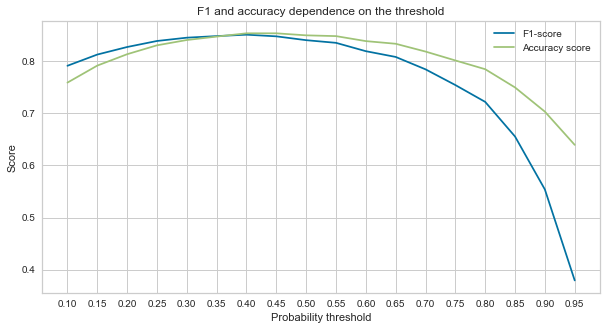

In [58]:
# find out the class weights
y_test_proba_pred = pd.Series(log_reg_best_2.predict_proba(X_test_poly)[:, 1])

# create a list for target metric and another one for accuracy
f1_scores = []
accuracy =[]

# possible decision thresholds
thresholds = np.arange(0.1, 1, 0.05)

# calculate metrics depending on the various decision thresholds
for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    accuracy.append(metrics.accuracy_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

# picturaze it 
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(thresholds, f1_scores, label='F1-score')
ax.plot(thresholds, accuracy, label='Accuracy score')
ax.set_title('F1 and accuracy dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()
ax.set_xticks(thresholds);

In [59]:
# the optimal threshold
threshold_opt = 0.4

# predict and calculate metrics with new threshold
y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
print('Test F1-score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Test F1-score: 0.8513
Test accuracy: 0.8540


### <center> <span style='color:blue'> **DECISION TREE**

#### <span style='color:green'> **Simple model**  

In [82]:
# train a simple decision tree with the given params
decision_tree = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,
    min_samples_leaf=3,
    random_state=42
)

# training the model
decision_tree.fit(X_train, y_train)

# predict and calculate metrics
y_train_pred = decision_tree.predict(X_train)
print('Train F1-score: {:.4f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Train accuracy: {:.4f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('_'*25)

y_test_pred = decision_tree.predict(X_test)
print('Test F1-score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train F1-score: 0.8322
Train accuracy: 0.8428
_________________________
Test F1-score: 0.8138
Test accuracy: 0.8237


#### <span style='color:green'> **Optimization**  

In [84]:
def optuna_tree(trial):
    """function to iterate over hyperparameters for decision tree
    
    Args:
        trial : hyperparameter class
      
    Returns:
        score(float): target metric - F1
    """
    
    # space for searching
    max_depth = trial.suggest_int('max_depth', 5, 15, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    # build a model
    decision_tree = tree.DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42)   
    
    # training the model
    decision_tree.fit(X_train, y_train)
    
    # compete a cross validation
    score = cross_val_score(decision_tree, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    
    return score

In [85]:
# finding best parameters
sampler = optuna.samplers.TPESampler(seed=42)
study_tree = optuna.create_study(study_name="DecisionTree", direction="maximize")
study_tree.optimize(optuna_tree, n_trials=50)

# build a model with best parameters
decision_tree_best = tree.DecisionTreeClassifier(**study_tree.best_params,random_state=42)

# training the model
decision_tree_best.fit(X_train, y_train)

# predict and calculate results for the testing sample
y_test_pred = decision_tree_best.predict(X_test)

print('Test f1 score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

[I 2022-12-19 14:11:28,029] A new study created in memory with name: DecisionTree
[I 2022-12-19 14:11:37,819] Trial 0 finished with value: 0.8166818482699065 and parameters: {'max_depth': 7, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 0 with value: 0.8166818482699065.
[I 2022-12-19 14:11:39,790] Trial 1 finished with value: 0.8083783260239011 and parameters: {'max_depth': 11, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.8166818482699065.
[I 2022-12-19 14:11:40,090] Trial 2 finished with value: 0.8246341215231073 and parameters: {'max_depth': 9, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8246341215231073.
[I 2022-12-19 14:11:40,370] Trial 3 finished with value: 0.7896900609835106 and parameters: {'max_depth': 14, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 2 with value: 0.8246341215231073.
[I 2022-12-19 14:11:40,665] Trial 4 finished with value: 0.7668090020157726 and parameters: {'max_depth':

Test f1 score: 0.8148
Test accuracy: 0.8276


#### <span style='color:green'> **Changing the decision threshold**  

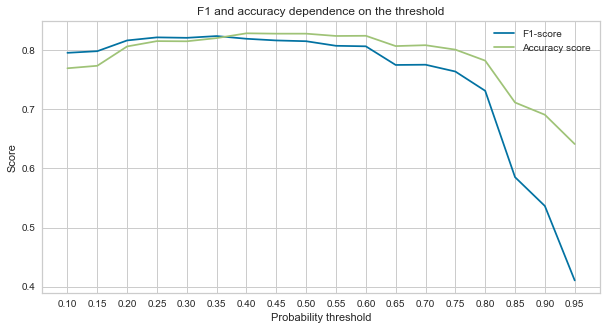

In [86]:
# find out the class weights
y_test_proba_pred = pd.Series(decision_tree_best.predict_proba(X_test)[:, 1]) # _best

# create a list for target metric and another one for accuracy
f1_scores = []
accuracy =[]

# possible decision thresholds
thresholds = np.arange(0.1, 1, 0.05)

# calculate metrics depending on the various decision thresholds
for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    accuracy.append(metrics.accuracy_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

# picturaze it 
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(thresholds, f1_scores, label='F1-score')
ax.plot(thresholds, accuracy, label='Accuracy score')
ax.set_title('F1 and accuracy dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()
ax.set_xticks(thresholds);

F1-score is a target metric, that's why we'll take threshold=0.35.

In [87]:
# the optimal threshold
threshold_opt = 0.35

# predict and calculate metrics with new threshold
y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
print('Test F1-score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Test F1-score: 0.8235
Test accuracy: 0.8201


### <center> <span style='color:blue'> **RANDOM FOREST**

#### <span style='color:green'> **Build a random forest model**  

In [65]:
# build this model
random_forest = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'entropy',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

# train our random forest
random_forest.fit(X_train, y_train)

# predict and calculate metrics for the training sample
y_train_pred = random_forest.predict(X_train)
print('Train F1 score: {:.4f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Train accuracy: {:.4f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('_' * 25)

# predict and calculate for the testing sample
y_test_pred = random_forest.predict(X_test)
print('Test F1 score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train F1 score: 0.8759
Train accuracy: 0.8815
_________________________
Test F1 score: 0.8436
Test accuracy: 0.8501


#### <span style='color:green'> **Optimization**  

In [66]:
def optuna_forest(trial):
    """function to iterate over hyperparameters for random forest
    
    Args:
        trial : hyperparameter class
      
    Returns:
        score(float): target metric - F1
    """
    
    # space for searching
    n_estimators = trial.suggest_int('n_estimators', 100, 500, 10)
    max_depth = trial.suggest_int('max_depth', 5, 15, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 10, 1)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    # build a model
    random_forest = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42)   
    
    # training the model
    random_forest.fit(X_train, y_train)
    
    # compete a cross validation
    score = cross_val_score(random_forest, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    
    return score

In [67]:
# finding best parameters
sampler = optuna.samplers.TPESampler(seed=42)
study_forest = optuna.create_study(study_name="RandomForest", direction="maximize")
study_forest.optimize(optuna_forest, n_trials=50)

# build a model with best parameters
random_forest_best = ensemble.RandomForestClassifier(**study_forest.best_params, random_state=42)

# training the model
random_forest_best.fit(X_train, y_train)

# predict and calculate results for the testing sample
y_test_pred = random_forest_best.predict(X_test)

print('Test f1 score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

[I 2022-12-19 13:43:27,547] A new study created in memory with name: RandomForest
[I 2022-12-19 13:43:31,250] Trial 0 finished with value: 0.8452545442382814 and parameters: {'n_estimators': 260, 'max_depth': 9, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8452545442382814.
[I 2022-12-19 13:43:37,589] Trial 1 finished with value: 0.8491542115920421 and parameters: {'n_estimators': 450, 'max_depth': 11, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8491542115920421.
[I 2022-12-19 13:43:41,074] Trial 2 finished with value: 0.8483991139378123 and parameters: {'n_estimators': 240, 'max_depth': 11, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8491542115920421.
[I 2022-12-19 13:43:45,671] Trial 3 finished with value: 0.8484895965392013 and parameters: {'n_estimators': 380, 'max_depth': 11, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 1 with value: 0.8491542115920421.
[I 2022-12-19 

Test f1 score: 0.8469
Test accuracy: 0.8531


#### <span style='color:green'> **Changing the decision threshold**  

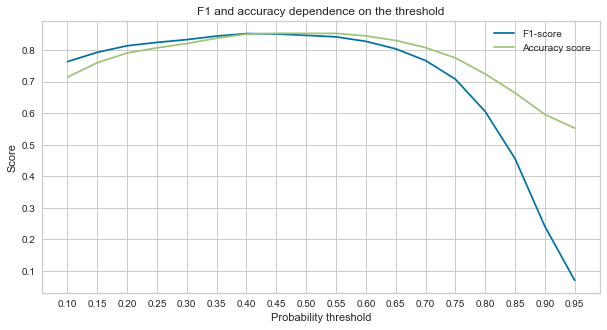

In [68]:
# find out the class weights
y_test_proba_pred = pd.Series(random_forest_best.predict_proba(X_test)[:, 1])

# create a list for target metric and another one for accuracy
f1_scores = []
accuracy =[]

# possible decision thresholds
thresholds = np.arange(0.1, 1, 0.05)

# calculate metrics depending on the various decision thresholds
for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    accuracy.append(metrics.accuracy_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

# picturaze it 
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(thresholds, f1_scores, label='F1-score')
ax.plot(thresholds, accuracy, label='Accuracy score')
ax.set_title('F1 and accuracy dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()
ax.set_xticks(thresholds);

In [69]:
# the optimal threshold
threshold_opt = 0.4

# predict and calculate metrics with new threshold
y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
print('Test F1-score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Test F1-score: 0.8526
Test accuracy: 0.8510


### <center> <span style='color:blue'> **GRADIENT BOOSTING**

#### <span style='color:green'> **Build a gradient boosting model**  

In [90]:
# build the model
gradient_boost = GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

# training the model
gradient_boost.fit(X_train, y_train)

# predict and calculate results for the training sample
y_train_pred = gradient_boost.predict(X_train)
print('Train f1 score: {:.4f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Train accuracy: {:.4f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('_'*25)

# predict and calculate results for the testing sample
y_test_pred = gradient_boost.predict(X_test)
print('Test f1 score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train f1 score: 0.9186
Train accuracy: 0.9233
_________________________
Test f1 score: 0.8423
Test accuracy: 0.8492


#### <span style='color:green'> **Optimization**

In [91]:
def optuna_grad_boost(trial):
    """function to iterate over hyperparameters for gradient boosting
    
    Args:
        trial : hyperparameter class
      
    Returns:
        score(float): target metric - F1
    """
    
    # space for searching
    n_estimators = trial.suggest_int('n_estimators', 100, 500, 10)
    max_depth = trial.suggest_int('max_depth', 5, 50, 2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, 2)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 1) 
    loss = trial.suggest_categorical('loss', ['log_loss', 'exponential'])
    
    # build a model
    gradient_boost = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        learning_rate=learning_rate,
        loss=loss,
        random_state=42)   
    
    # training the model
    gradient_boost.fit(X_train, y_train)
    
    # compete a cross validation
    score = cross_val_score(gradient_boost, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    
    return score

In [92]:
# finding best parameters
sampler = optuna.samplers.TPESampler(seed=42)
study_grad_boost = optuna.create_study(study_name="GradientBoosting", direction="maximize")
study_grad_boost.optimize(optuna_grad_boost, n_trials=50)

# build a model with best parameters
grad_boost_best = GradientBoostingClassifier(**study_grad_boost.best_params, random_state=42)

# training the model
grad_boost_best.fit(X_train, y_train)

# predict and calculate results for the testing sample
y_test_pred = grad_boost_best.predict(X_test)

print('Test f1 score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

[I 2022-12-19 14:15:23,511] A new study created in memory with name: GradientBoosting
[I 2022-12-19 14:15:43,014] Trial 0 finished with value: 0.8457530266373515 and parameters: {'n_estimators': 140, 'max_depth': 13, 'min_samples_leaf': 15, 'learning_rate': 0.19692650097060743, 'loss': 'exponential'}. Best is trial 0 with value: 0.8457530266373515.
[I 2022-12-19 14:15:58,043] Trial 1 finished with value: 0.8445610724977277 and parameters: {'n_estimators': 150, 'max_depth': 25, 'min_samples_leaf': 9, 'learning_rate': 0.6948934549413329, 'loss': 'exponential'}. Best is trial 0 with value: 0.8457530266373515.
[I 2022-12-19 14:16:06,907] Trial 2 finished with value: 0.7722054742463271 and parameters: {'n_estimators': 500, 'max_depth': 33, 'min_samples_leaf': 1, 'learning_rate': 0.5783351683843886, 'loss': 'log_loss'}. Best is trial 0 with value: 0.8457530266373515.
[I 2022-12-19 14:16:18,557] Trial 3 finished with value: 0.852428679476937 and parameters: {'n_estimators': 190, 'max_depth': 

Test f1 score: 0.8464
Test accuracy: 0.8537


#### <span style='color:green'> **Changing the decision threshold**  

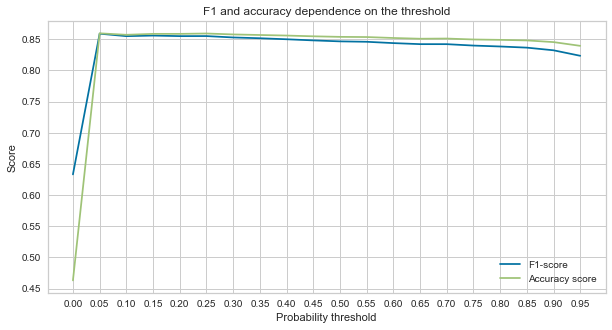

In [94]:
# find out the class weights
y_test_proba_pred = pd.Series(grad_boost_best.predict_proba(X_test)[:, 1])

# create a list for target metric and another one for accuracy
f1_scores = []
accuracy =[]

# possible decision thresholds
thresholds = np.arange(0, 1, 0.05)

# calculate metrics depending on the various decision thresholds
for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    accuracy.append(metrics.accuracy_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

# picturaze it 
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(thresholds, f1_scores, label='F1-score')
ax.plot(thresholds, accuracy, label='Accuracy score')
ax.set_title('F1 and accuracy dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()
ax.set_xticks(thresholds);

In [95]:
threshold_opt = 0.05

# predict and calculate metrics with new threshold
y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
print('Test F1-score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Test F1-score: 0.8588
Test accuracy: 0.8594


### <center> <span style='color:blue'> **STACKING**

In [75]:
estimators = [
    ('lg', log_reg),
    ('dt', decision_tree),
    ('rf', random_forest),
    ('gb', gradient_boost)
]

stack_forest = StackingClassifier(
    estimators=estimators,
    final_estimator=ensemble.RandomForestClassifier(n_estimators=10,
                                                    max_depth=6,
                                                    min_samples_leaf=3,
                                                    criterion='entropy',
                                                    random_state=42)
)

# training the model
stack_forest.fit(X_train, y_train)

# predict and calculate results for the training sample
y_train_pred = stack_forest.predict(X_train)
print('Train f1 score: {:.4f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Train accuracy: {:.4f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('_' * 25)

# predict and calculate results for the testing sample
y_test_pred = stack_forest.predict(X_test)
print('Test f1 score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train f1 score: 0.9107
Train accuracy: 0.9137
_________________________
Test f1 score: 0.8491
Test accuracy: 0.8528


## <center> <span style='color:red'> **General conclusion**  
Using various processing methods, searching for complex dependencies, creating new features, building simple and ensemble machine learning models, optimizing hyperparameters, and changing the decision threshold, we managed to achieve a clear increase in the target metric.

Target metric results (F1-score) for different machine learning models:
- logistic regression = 0.8513
- decision tree = 0.8235
- random forest = 0.8526
- gradient boosting = 0.8588
- stacking = 0.8491

The gradient boosting model has the best result. Target metric F1 = **0.8588**.  

The most important features are those that are associated with interaction with the client - the duration of the conversation, the number of contacts, the method of interaction, past interaction experience, etc. In addition, such signs as age, month and even a specific day are of great importance.
Thus, using the constructed machine learning model, it is possible to predict with high accuracy for a particular client how likely a deposit will be taken.

This work is an improved version of [the basic educational solution](https://github.com/AlekaranDS/alekaran/blob/AlekaranDS-ms/Project%204.%20Classification/PJ%204.%20Classification.%20BASELINE.ipynb) to the problem.
